In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import torch
import torch.nn as nn
import torch._dynamo
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RMSprop
from torch.utils.data import Dataset, DataLoader

In [146]:
sns.set_theme(style="darkgrid")

In [147]:
column_names = ['classification'] + [f'llq_{i}' for i in range(1, 22)]+ [f'hlq_{i}' for i in range(22, 29)]
data = pd.read_csv("HIGGS_8K.csv", names=column_names)
data = data.apply(pd.to_numeric, errors='coerce')

low_X = data.iloc[:,0:22]
high_X = data.iloc[:,22:]

signal = data['classification']
signal.describe()

count    8001.000000
mean        0.523935
std         0.499458
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: classification, dtype: float64

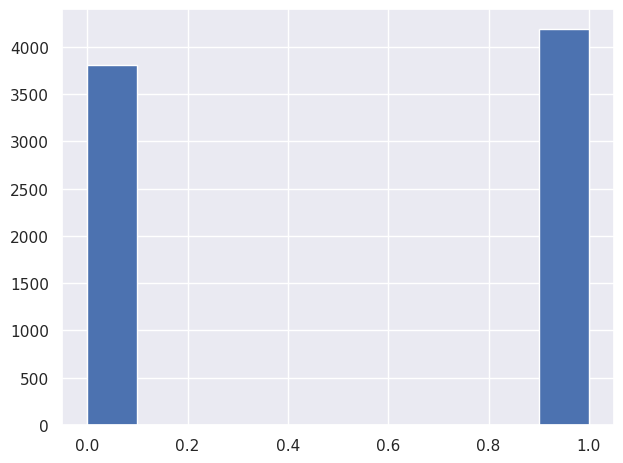

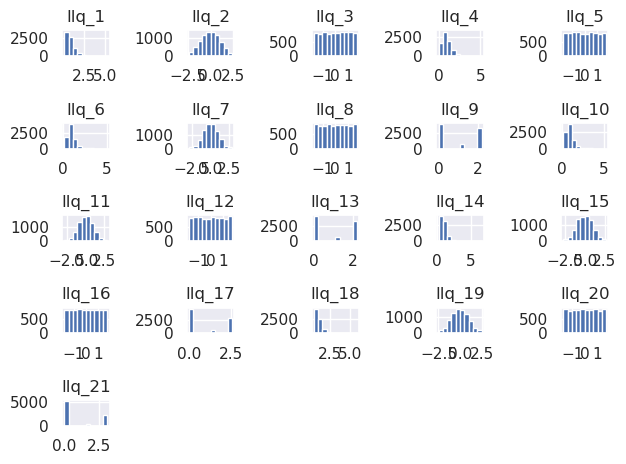

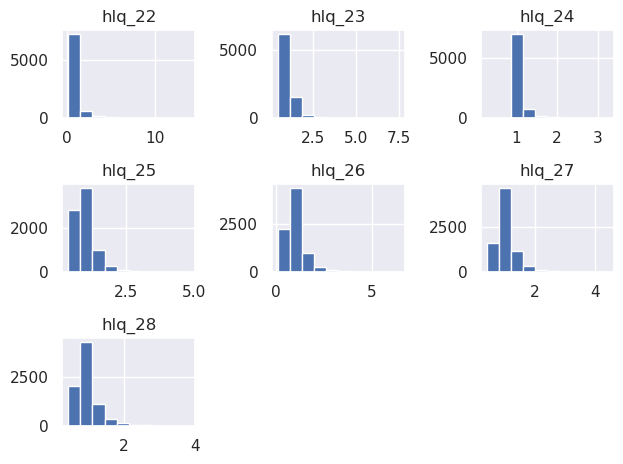

In [148]:
signal.hist()

plt.tight_layout()
plt.show()

data.iloc[:, 1:22].hist()
plt.tight_layout()
plt.show()

data.iloc[:, 22:].hist()
plt.tight_layout()
plt.show()

Removed variables due to high correlation: {'hlq_27'}


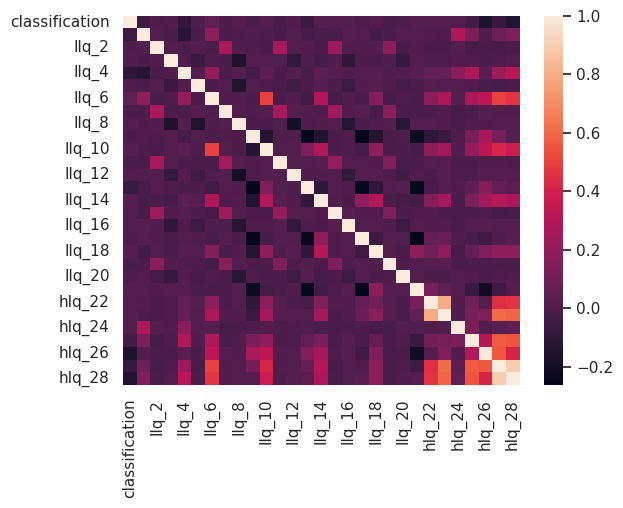

In [149]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=False)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
filtered_corr = corr_matrix.mask(mask)

threshold = 0.8

high_corr_pairs = filtered_corr.abs().stack()
to_drop = set()

for (col1, col2), corr_value in high_corr_pairs.items():
    if corr_value > threshold:
        to_drop.add(col2)

print("Removed variables due to high correlation:", to_drop)

data_filtered = data.drop(columns=list(to_drop))

In [150]:
low_X = low_X.to_numpy()
high_X = high_X.to_numpy()
signal = signal.to_numpy()

lowX_train, lowX_test, lowy_train, lowy_test = train_test_split(low_X, signal, test_size=0.2, random_state=42)
highX_train, highX_test, highy_train, highy_test = train_test_split(high_X, signal, test_size=0.2, random_state=42)

# Pytorch

In [151]:
scaler = StandardScaler()
lowX_train = scaler.fit_transform(lowX_train)
lowX_test = scaler.transform(lowX_test)
highX_train = scaler.fit_transform(highX_train)
highX_test = scaler.transform(highX_test)

lowX_train = np.nan_to_num(lowX_train, nan=0.0)
lowX_test = np.nan_to_num(lowX_test, nan=0.0)

highX_train = np.nan_to_num(highX_train, nan=0.0)
highX_test = np.nan_to_num(highX_test, nan=0.0)

print(np.isnan(lowX_train).any(), np.isinf(lowX_train).any())
print(np.max(lowX_train), np.min(lowX_train))


False False
11.229019163975957 -2.955073032613098


In [152]:
lowX_train  = torch.from_numpy(lowX_train).float()
lowX_test = torch.from_numpy(lowX_test).float()
highX_train = torch.from_numpy(highX_train).float()
highX_test = torch.from_numpy(highX_test).float()

lowy_train = torch.from_numpy(lowy_train).float().view(-1,1)
lowy_test = torch.from_numpy(lowy_test).float().view(-1,1)
highy_train = torch.from_numpy(highy_train).float().view(-1,1)
highy_test = torch.from_numpy(highy_test).float().view(-1,1)


## Low-Level

In [153]:
class ANN(nn.Module):
    def __init__(self, input_dim):
        super(ANN, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )
    
    def forward(self, x):
        return self.sequential(x)

In [154]:
model = ANN(input_dim=lowX_train.size(1))

Loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [155]:
# 8. Save the Model (optional)
#torch.save(model.state_dict(), 'binary_classifier.pth')

In [156]:
train_data = TensorDataset(lowX_train, lowy_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [157]:
torch._dynamo.config.suppress_errors = True

# Train neural network
epochs = 350
for epoch in range(epochs):  
    for batch_idx, (data, target) in enumerate(train_loader):       
        optimizer.zero_grad()       
        output = model(data)     
        loss = Loss(output, target)
        loss.backward()
        optimizer.step()
    print("Epoch:", epoch+1, "\tLoss:", loss.item())

Epoch: 1 	Loss: 0.003222445026040077
Epoch: 2 	Loss: 0.0004649280454032123
Epoch: 3 	Loss: 0.00035934700281359255
Epoch: 4 	Loss: 0.0001474887685617432
Epoch: 5 	Loss: 8.468130545224994e-05
Epoch: 6 	Loss: 5.0187562010250986e-05
Epoch: 7 	Loss: 3.1554282031720504e-05
Epoch: 8 	Loss: 4.085660111741163e-05
Epoch: 9 	Loss: 2.2244410502025858e-05
Epoch: 10 	Loss: 2.157231756427791e-05
Epoch: 11 	Loss: 1.4555683264916297e-05
Epoch: 12 	Loss: 1.1963770703005139e-05
Epoch: 13 	Loss: 9.137904271483421e-06
Epoch: 14 	Loss: 5.497377060237341e-06
Epoch: 15 	Loss: 5.078517915535485e-06
Epoch: 16 	Loss: 5.3555650083580986e-06
Epoch: 17 	Loss: 4.576480478135636e-06
Epoch: 18 	Loss: 3.4909608075395226e-06
Epoch: 19 	Loss: 2.357093762839213e-06
Epoch: 20 	Loss: 3.0760975278099068e-06
Epoch: 21 	Loss: 1.9971735127910506e-06
Epoch: 22 	Loss: 1.9786878056038404e-06
Epoch: 23 	Loss: 1.741293772283825e-06
Epoch: 24 	Loss: 1.391359091940103e-06
Epoch: 25 	Loss: 1.8766913854051381e-06
Epoch: 26 	Loss: 1.4365

In [158]:
# Evaluate neural network
with torch.no_grad():
    output = model(lowX_test) # Drives x_test to the network 
    test_loss = Loss(output, lowy_test)
    preds = torch.sigmoid(output)
    test_accuracy = (preds.round().view(-1) == lowy_test.view(-1)).float().mean()

In [159]:
output

tensor([[ 19.1826],
        [ 17.4095],
        [ 18.6844],
        ...,
        [-28.5470],
        [-27.5757],
        [-30.5206]])

In [160]:
print(f"Test Loss:{test_loss.item()}\tTest Accuracy:{test_accuracy.item():.2f}")

Test Loss:4.290848565347005e-09	Test Accuracy:1.00


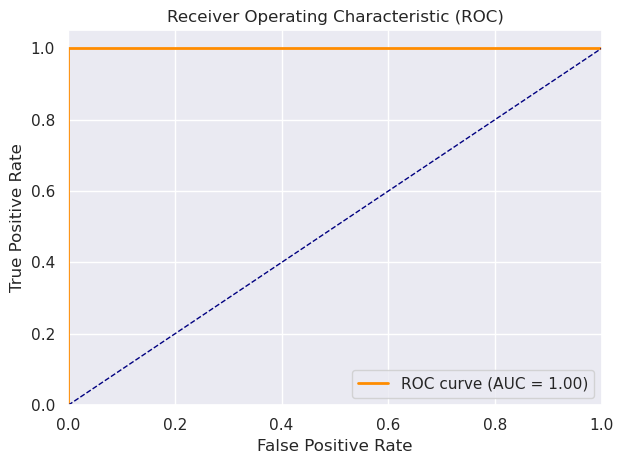

In [161]:
with torch.no_grad():
    probs = model(lowX_test)  # output is already sigmoid if using nn.BCELoss()

# Convert tensors to NumPy
y_true = lowy_test.view(-1).cpu().numpy()
y_scores = probs.view(-1).cpu().numpy()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## High-level

In [162]:
class ANN(nn.Module):
    def __init__(self, input_dim):
        super(ANN, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_dim, 20),
            nn.ReLU(50),
            nn.Linear(20, 10),
            nn.ReLU(25),
            nn.Linear(10, 5),
            nn.ReLU(20),
            #nn.Dropout(0.25),
            nn.Linear(5, 1)
        )
    
    def forward(self, x):
        return self.sequential(x)

In [163]:
model = ANN(input_dim=highX_train.size(1))

Loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [164]:
train_data = TensorDataset(highX_train, highy_train)
train_loader = DataLoader(train_data, batch_size=12, shuffle=True)

In [165]:
torch._dynamo.config.suppress_errors = True

# Train neural network
epochs = 350
for epoch in range(epochs):  
    for batch_idx, (data, target) in enumerate(train_loader):       
        optimizer.zero_grad()       
        output = model(data)     
        loss = Loss(output, target)
        loss.backward()
        optimizer.step()
    print("Epoch:", epoch+1, "\tLoss:", loss.item())

Epoch: 1 	Loss: 0.6819894313812256
Epoch: 2 	Loss: 0.6911852955818176
Epoch: 3 	Loss: 0.6767940521240234
Epoch: 4 	Loss: 0.6983610391616821
Epoch: 5 	Loss: 0.7536953091621399
Epoch: 6 	Loss: 0.6164638996124268
Epoch: 7 	Loss: 0.6579712629318237
Epoch: 8 	Loss: 0.6171661615371704
Epoch: 9 	Loss: 0.6641149520874023
Epoch: 10 	Loss: 0.6087633371353149
Epoch: 11 	Loss: 0.5409637689590454
Epoch: 12 	Loss: 0.45706456899642944
Epoch: 13 	Loss: 0.5994018316268921
Epoch: 14 	Loss: 0.823067307472229
Epoch: 15 	Loss: 0.7032720446586609
Epoch: 16 	Loss: 0.6735457181930542
Epoch: 17 	Loss: 0.6328662037849426
Epoch: 18 	Loss: 0.521152138710022
Epoch: 19 	Loss: 0.6135587692260742
Epoch: 20 	Loss: 0.8119028806686401
Epoch: 21 	Loss: 0.6649278402328491
Epoch: 22 	Loss: 0.41522884368896484
Epoch: 23 	Loss: 0.6724566221237183
Epoch: 24 	Loss: 0.808668315410614
Epoch: 25 	Loss: 0.39967870712280273
Epoch: 26 	Loss: 0.678260862827301
Epoch: 27 	Loss: 0.5264919996261597
Epoch: 28 	Loss: 0.6555907726287842
Ep

In [166]:
# Evaluate neural network
with torch.no_grad():
    output = model(highX_test) # Drives x_test to the network 
    test_loss = Loss(output, lowy_test)
    preds = torch.sigmoid(output)
    test_accuracy = (preds.round().view(-1) == lowy_test.view(-1)).float().mean()

In [167]:
output

tensor([[ 0.3309],
        [ 1.1395],
        [-0.0951],
        ...,
        [-2.5541],
        [-0.5966],
        [-1.9538]])

In [168]:
print(f"Test Loss:{test_loss.item()}\tTest Accuracy:{test_accuracy.item():.2f}")

Test Loss:0.5710322856903076	Test Accuracy:0.70


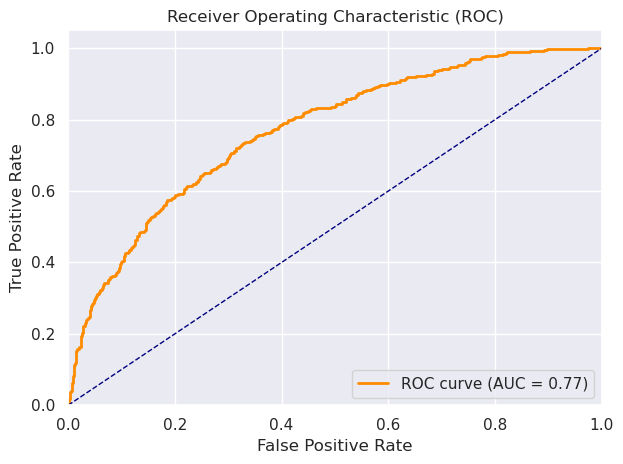

In [169]:
with torch.no_grad():
    probs = model(highX_test)

# Convert tensors to NumPy
y_true = highy_test.view(-1).cpu().numpy()
y_scores = probs.view(-1).cpu().numpy()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scikit-learn Classifiers

In [183]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score

In [171]:
scaler = StandardScaler()
lowX_train = scaler.fit_transform(lowX_train)
lowX_test = scaler.transform(lowX_test)
highX_train = scaler.fit_transform(highX_train)
highX_test = scaler.transform(highX_test)

### Random Forest

In [198]:
#for llq
forest_l = RandomForestClassifier(n_estimators=300, criterion='entropy', max_depth=100, min_samples_split=5,  min_samples_leaf=1, max_features='sqrt', random_state=42)
forest_l.fit(lowX_train, lowy_train)

#for hlq
forest_h = RandomForestClassifier(n_estimators=300, criterion='entropy', max_depth=100, min_samples_split=5,  min_samples_leaf=1, max_features='sqrt', random_state=42)
forest_h.fit(highX_train, highy_train)

/run/media/burpsploit/Crucial_M2/ml/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/run/media/burpsploit/Crucial_M2/ml/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(criterion='entropy', max_depth=100, min_samples_split=5,
                       n_estimators=300, random_state=42)

In [199]:
forest_l_pred = forest_l.predict(lowX_test)
forest_h_pred = forest_h.predict(highX_test)

In [201]:
cm_low_rfc = confusion_matrix(lowy_test, forest_l_pred)
accuracy_low_rfc = accuracy_score(lowy_test, forest_l_pred)

print(f"The confusion matrix for low level quantities, using the Random Forest classifier is:\n{cm_low_rfc}")
print(f"The accuracy for low level quantities, using the Random Forest classifier is: {accuracy_low_rfc}\n")

cm_high_rfc = confusion_matrix(highy_test, forest_h_pred)
accuracy_high_rfc = accuracy_score(highy_test, forest_h_pred)

print(f"The confusion matrix for high level quantities, using the Random Forest classifier is:\n{cm_high_rfc}")
print(f"The accuracy for high level quantities, using the Random Forest classifier is: {accuracy_high_rfc}\n")

The confusion matrix for low level quantities, using the Random Forest classifier is:
[[771   0]
 [  0 830]]
The accuracy for low level quantities, using the Random Forest classifier is: 1.0

The confusion matrix for high level quantities, using the Random Forest classifier is:
[[513 258]
 [234 596]]
The accuracy for high level quantities, using the Random Forest classifier is: 0.6926920674578388



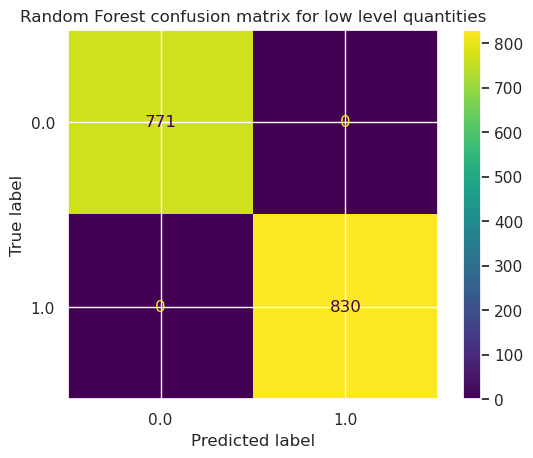

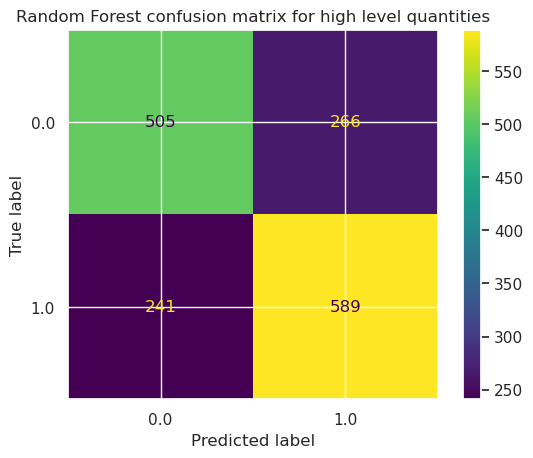

In [189]:
#for low level quantities
disp_low = ConfusionMatrixDisplay(confusion_matrix=cm_low_rfc, display_labels=forest_l.classes_)
disp_low.plot()
plt.title("Random Forest confusion matrix for low level quantities")

#for low level quantities
disp_high = ConfusionMatrixDisplay(confusion_matrix=cm_high_rfc, display_labels=forest_h.classes_)
disp_high.plot()
plt.title("Random Forest confusion matrix for high level quantities")

plt.show()

### Logistic Regression

In [226]:
#for llq
log_l = LogisticRegression(max_iter=400, penalty='l2',C=0.1,solver='newton-cholesky',tol=1e-4,random_state=42)
log_l.fit(lowX_train, lowy_train)

#for hlq
log_h = LogisticRegression(max_iter=400, penalty='l2',C=0.1,solver='newton-cholesky',tol=1e-4, random_state=42)
log_h.fit(highX_train, highy_train)

/run/media/burpsploit/Crucial_M2/ml/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/run/media/burpsploit/Crucial_M2/ml/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.1, max_iter=400, random_state=42,
                   solver='newton-cholesky')

In [227]:
log_l_pred = log_l.predict(lowX_test)
log_h_pred = log_h.predict(highX_test)

In [228]:
cm_low_log = confusion_matrix(lowy_test, log_l_pred)
accuracy_low_log = accuracy_score(lowy_test, log_l_pred)

print(f"The confusion matrix for low level quantities, using the Logistic Regression is:\n{cm_low_log}")
print(f"The accuracy for low level quantities, using the Logistic Regression is: {accuracy_low_log}\n")

cm_high_log = confusion_matrix(highy_test, log_h_pred)
accuracy_high_log = accuracy_score(highy_test, log_h_pred)

print(f"The confusion matrix for high level quantities, using the Logistic Regression is:\n{cm_high_log}")
print(f"The accuracy for high level quantities, using the Logistic Regression is: {accuracy_high_log}\n")

The confusion matrix for low level quantities, using the Logistic Regression is:
[[771   0]
 [  0 830]]
The accuracy for low level quantities, using the Logistic Regression is: 1.0

The confusion matrix for high level quantities, using the Logistic Regression is:
[[352 419]
 [173 657]]
The accuracy for high level quantities, using the Logistic Regression is: 0.6302311055590256



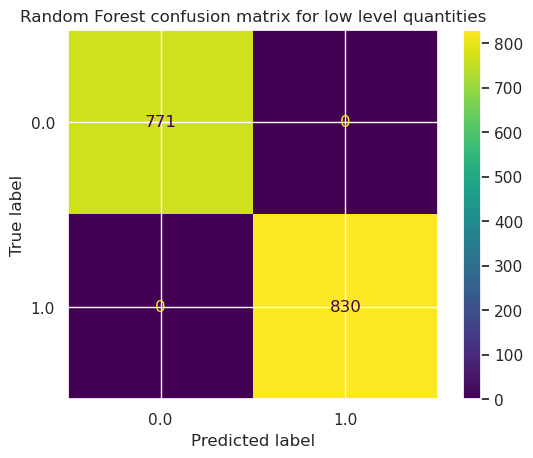

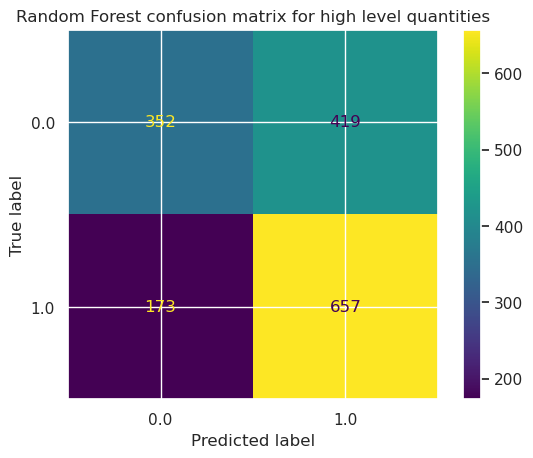

In [229]:
#for low level quantities
disp_low = ConfusionMatrixDisplay(confusion_matrix=cm_low_log, display_labels=log_l.classes_)
disp_low.plot()
plt.title("Random Forest confusion matrix for low level quantities")

#for low level quantities
disp_high = ConfusionMatrixDisplay(confusion_matrix=cm_high_log, display_labels=log_h.classes_)
disp_high.plot()
plt.title("Random Forest confusion matrix for high level quantities")

plt.show()